In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Boy in sequined prom dress ‘living his best life’
What does egg freezing have to do with your employer?
Highland Park shooting suspect considered second attack
Calls for downblousing to be made a criminal offence in England and Wales
Call for higher animal welfare standards for Parma ham pigs
Police officers 'photographed and manipulated body of suicide victim'
Jerry Harris: Star of Netflix's Cheer sentenced to 12 years
Caerphilly: Circus acrobat injured in human cannonball stunt
The problems start at the top, Javid tells PM
Steve Barclay: What will new health secretary tackle first?
Who is Nadhim Zahawi? Iraqi refugee to chancellor
The Papers: Johnson 'fights for life' and 'stares down mutiny'
Former cameraman Peter Jouvenal speaks following release
Fourth Thor film is 'funny but silly', critics say
Australia floods: Unfounded cloud seeding claims spread online
Hemel Hempstead mother's funding plea for daughter's rare disease
Mumbai: 

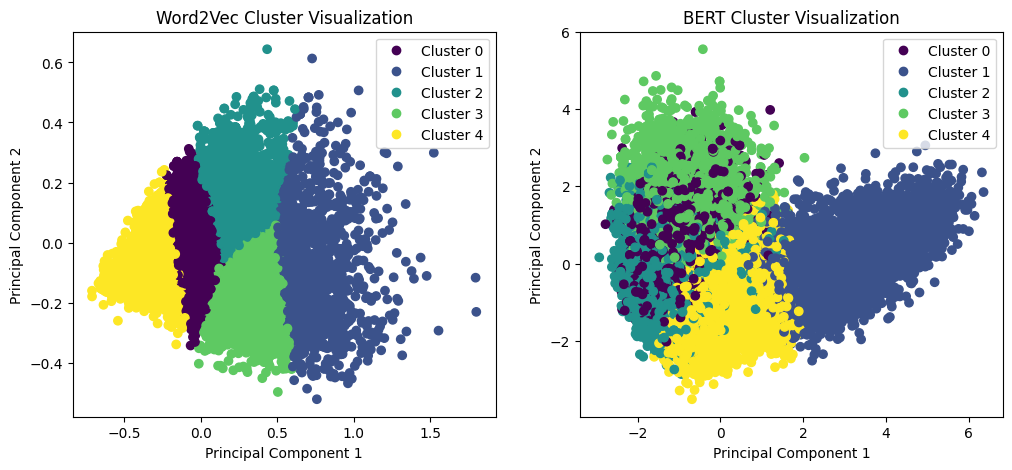

In [3]:
# Step 1: Import necessary libraries
import pandas as pd
import gensim
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 2: Load the BBC News Classification Dataset
# Assuming you have uploaded the dataset CSV file to Google Colab
df = pd.read_csv('bbc_news.csv')  # Replace 'your_dataset.csv' with the actual dataset filename

# Step 3: Data Preprocessing
# For this example, we'll use the 'description' column as the text data
# You may need to perform additional text preprocessing (e.g., stopwords removal, stemming)
text_data = df['description']
titles = df['title']
pubDates = df['pubDate']
guids = df['guid']
links = df['link']

# Step 4: Feature Extraction (Word2Vec Embeddings)
sentences = [text.split() for text in text_data]
model_w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)  # Adjust parameters as needed

# Generate Document Embeddings
def document_vector(model, text):
    words = text.split()
    vector = sum([model.wv[word] for word in words if word in model.wv])
    return vector / len(vector)

doc_embeddings_w2v = [document_vector(model_w2v, text) for text in text_data]

# Step 5: Feature Extraction (BERT-based Representation)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_bert = BertModel.from_pretrained('bert-base-uncased')

encoded_data = [tokenizer(text, padding=True, truncation=True, return_tensors='pt') for text in text_data]

bert_embeddings = []
with torch.no_grad():
    for data in encoded_data:
        outputs = model_bert(**data)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Average pooling over tokens
        bert_embeddings.append(embeddings.numpy())

bert_embeddings = [embedding.flatten() for embedding in bert_embeddings]

# Step 6: Clustering (K-Means) for Word2Vec Embeddings
num_clusters = 5  # You can adjust the number of clusters
kmeans_w2v = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_w2v.fit(doc_embeddings_w2v)

# Step 7: Clustering (K-Means) for BERT Embeddings
kmeans_bert = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_bert.fit(bert_embeddings)

# Step 8: Visualize the Clusters using PCA
pca = PCA(n_components=2)

# PCA for Word2Vec Embeddings
reduced_features_w2v = pca.fit_transform(doc_embeddings_w2v)

# PCA for BERT Embeddings
reduced_features_bert = pca.fit_transform(bert_embeddings)

# Create subplots for Word2Vec and BERT visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Word2Vec Visualization
scatter_w2v = ax1.scatter(reduced_features_w2v[:, 0], reduced_features_w2v[:, 1], c=kmeans_w2v.labels_, cmap='viridis')
ax1.set_title('Word2Vec Cluster Visualization')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')

# BERT Visualization
scatter_bert = ax2.scatter(reduced_features_bert[:, 0], reduced_features_bert[:, 1], c=kmeans_bert.labels_, cmap='viridis')
ax2.set_title('BERT Cluster Visualization')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')

# Add legends
legend_labels = [f'Cluster {i}' for i in range(num_clusters)]
ax1.legend(handles=scatter_w2v.legend_elements()[0], labels=legend_labels)
ax2.legend(handles=scatter_bert.legend_elements()[0], labels=legend_labels)

# Step 9: Advanced Analysis and Visualization with Additional Attributes
# Display additional attributes (e.g., titles, pubDates) alongside cluster analysis
for cluster_id in range(num_clusters):
    cluster_articles = [titles[i] for i, label in enumerate(kmeans_w2v.labels_) if label == cluster_id]
    print(f"Cluster {cluster_id} Titles:")
    for article in cluster_articles:
        print(article)
    print("\n")

# Show the plot
plt.show()